## Lit review
Similar projects used:
* OLS
* Deep Learning
    * Gradient based networks
    

In [1]:
# some tehcnicalities for working on the campus computers
import os

import sys
sys.path.append(r'R:/JoePriceResearch/Python/Anaconda3/Lib/site-packages')

In [16]:
import itertools
import operator
import re

import pandas as pd # getting the data
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

seed = 17

# suppressing warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
df = pd.read_csv('ICPSR_04572/DS0001/04572-0001-Data.tsv', sep='\t')
df2 = pd.read_csv('ICPSR_04572/DS0002/04572-0002-Data.tsv', sep='\t')
print('first part shape:',df.shape)
print('second part shape:',df2.shape)
print(all(df2.columns == df.columns))
df = df.append(df2)
print('all together shape:',df.shape)
df.head()

first part shape: (3686, 3374)
second part shape: (14499, 3374)
True
all together shape: (18185, 3374)


,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,V0010,...,CS_INCDA,CS_INCJ,CS_INCA,CH_NUMCAR,CH_NUMCAR1,CH_NUMCAR2,CH_NUMCAR3,CH_NUMCAR4,CH_NUMCAR5,CH_CRIM_HISTORY
0,15717,10,201,2,2,0,5,10,215,99,...,0,0,0,0,1,1,1,1,1,2
1,15718,10,201,2,2,0,5,8,310,99,...,0,0,0,0,1,1,1,1,1,2
2,15719,10,201,2,2,0,5,2,145,99,...,0,0,0,0,1,1,1,1,1,2
3,15720,10,201,2,2,0,5,6,150,99,...,0,0,0,0,1,1,1,1,1,2
4,15721,10,201,2,2,0,4,11,183,99,...,0,0,1,1,2,1,2,2,2,1


## Feature cleaning and Engineering

In [4]:
# all of these values are missing data so we will replace them with np.nan
nan_list = [99, 999, 9999, 9999.99, 99999, 99999.99, 999999, 999999.99,9999999,9999999.99,
            99999999, 99999999.99, 9999999.98,9999998.00, 9999999.98, 9999998.00, 9999997.00]
df.replace(nan_list, np.nan, inplace=True)

We need to clean up some variables that we will be using as outcomes and things that come as a direct result like disciplinary action

In [5]:
# this block has the violations and discipline
discipline_cols = [f'V{i}' for i in range(2500, 2565)]
discipline = df.loc[:,discipline_cols]
df.drop(columns=discipline_cols, inplace=True)

In [6]:
# renaming target variables
targets = {
'V2518':'drugs',
'V2519':'n_drugs',
'V2520':'alcohol',
'V2521':'n_alcohol',
'V2522':'weapon_poss',
'V2523':'n_reapon_poss',
'V2524':'stolen_prop',
'V2525':'n_stolen_prop',
'V2526':'poss_unauth',
'V2527':'n_poss_unauth',
'V2528':'verbal_staff',
'V2527':'n_verbal_staff',
'V2530':'phys_staff',
'V2531':'n_phys_staff',
'V2532':'verb_inmate',
'V2533':'n_verb_inmate',
'V2534':'phys_inmate',
'V2535':'n_phys_inmate',
'V2536':'att_escape',
'V2537':'n_att_escape',
'V2538':'out_place',
'V2539':'n_out_place',
'V2540':'disobey_ord',
'V2541':'n_disobey_ord',
'V2542':'maj_violation',
'V2543':'n_maj_violation',
'V2544':'minor_violation',
'V2545':'n_minor_violation',
'V2546':'other_violation',
'V2547':'n_other_violation',
'V2549':'recent_violations',
}
discipline.rename(mapper=targets, axis='columns', inplace=True)

In [7]:
# we only need to rename these ones for now and we will work with the other ones if we see a particular importance
varnames = {'V0001':'id','V00014':'age','V0019':'hispanic','V0037':'white','V0038':'black',
            'V0039':'native_american','V0040':'asian','V0041':'pacfic_islander',
            'V0042':'other_race','V0043':'unknown_race','V0046':'born_us',
            'V0058':'marital_status','V0059':'military_service','V0079':'time_mil_service',
            'V0083':'corrently_sentenced','V0084':'crim_stat_arrest','V0085':'wait_judicial_res',
            'V0086':'wait_trial','V0087':'wait_parole','V0088':'judge_informed_time',
            'V0089':'crim_stat_last_arrest','V0090':'held_other_authorities','V0091':'held_safekeeping',
            'V0092':'held_other_reason','V2603':'prison_type',
            # use offense codes for replacement to get categories of crimes
                # 94,96,98,100,102 previous holding offenses
                # 95,97,999,101,103 number of charges for said offenses
                # 115,117,119,121,123 current holding offenses
                # 116,118,120,122,124
            'V0125':'arrest_month','V0127':'arrest_year',
            'V0638':'crim_just_status',
            # 639 - : pleas and trial info
           }
df.rename(mapper=varnames, axis='columns', inplace=True)

In [8]:
# create height variable
df['height'] = [(x * 12) if x < 90 else np.nan for x in df['V0007']]
df['V0008'] = [y if y < 97 else 0 for y in df['V0008']]
df['height'] = [x + y if y < 13 else y for x, y in zip(df['height'], df['V0008'])]

In [9]:
# create binary plea or guilty verdict variable
df['plea'] = df['V0639'].replace(99,np.nan).fillna(df['V0640'].replace([99,2],[np.nan,1])).fillna(df['V0641'].replace([99,3],[np.nan,1])).fillna(df['V0642'].replace([99,4],[np.nan,1])).fillna(df['V0643'].replace([99,5],[np.nan,1]))
df['found_guilty'] = df['V0647'].replace([2,7,8,9],[0,np.nan,np.nan,np.nan])

In [17]:
# generate time since arrest variables
df['mth_int_arr'] = (df['V2955'].replace(9999, np.nan) - df['V2953'].replace(9999,np.nan)) * 12 + (df['V2956'].replace(9999,np.nan) - df['V2952'].replace(9999, np.nan))
df['mth_int_arr'][df['mth_int_arr'] < 0] = np.nan

In [11]:
# Many values are codes as 1 and 2 for yes and no respectively we will change 2s to 0s
two_to_zero = ['SES_PARENTS_INCARCERATED','SES_FAMILY_INCARCERATED', 'DRUG_ANY', 'DRUG_COCRK','DRUG_HEROPIT',
 'DRUG_DEPRES',
 'DRUG_STIMU','DRUG_HALLU', 'DRUG_MARIJ', 'DRUG_INHAL', 'DRUG_METHAM', 'DRUG_COCRK', 'DRUG_DEPREG',
 'DRUG_STIMREG','DRUG_HALUREG', 'DRUG_MARIJREG', 'DRUG_INHALREG', 'DRUG_METHAMREG','DRUG_ANYMTH', 'DRUG_COCRKREG',
 'DRUG_DEPMTH','DRUG_STIMMTH','DRUG_HALUMTH', 'DRUG_MARIJMTH', 'DRUG_INHALMTH', 'DRUG_METHAMTH',
 'DRUG_ANYTME', 'DRUG_COCRKTME','DRUG_HROPTME', 'DRUG_DEPTME', 'DRUG_STIMTME','DRUG_HALUTME', 'DRUG_MARIJTME',
 'DRUG_METHATME', 'DRUG_NUMPOS_CAGE', 'DRUG_ANY_ALCDRUGTME', 'DRUG_DROVE_ALCDRUG', 'DRUG_CARACCIDENT_ALCDRUG', 
 'DRUG_DISPUTES_ALCDRUG', 'DRUG_FIRED_ALCDRUG', 'DRUG_WORKTROUBLE_ALCDRUG', 'DRUG_ARRESTED_ALCDRUG',
 'DRUG_FIGHT_ALCDRUG', 'DRUG_ANYTRT', 'DRUG_ANYPGM', 'DRUG_HEROIN_CB', 'DRUG_OPIATES_CB', 'DRUG_METHAMP_CB',
 'DRUG_AMPH_CB','DRUG_METHAQ_CB','DRUG_BARB_CB','DRUG_TRANQ_CB', 'DRUG_CRACK_CB','DRUG_COCAINE_CB',
 'DRUG_PCP_CB', 'DRUG_HALLU_CB', 'DRUG_MARIJ_CB', 'DRUG_OTHERDRUG_CB', 'DRUG_INHAL_CB', 'DRUG_INJECT_CB',
 'DRUG_HEROINREG_CB', 'DRUG_OPIATESREG_CB', 'DRUG_METHAMPREG_CB',
 'DRUG_AMPHREG_CB','DRUG_METHAQREG_CB','DRUG_BARBREG_CB','DRUG_TRANQREG_CB', 'DRUG_CRACKREG_CB','DRUG_COCREG_CB',
 'DRUG_PCPREG_CB', 'DRUG_HALLUREG_CB', 'DRUG_MARIJREG_CB', 'DRUG_OTHERDRUGREG_CB', 'DRUG_INHALREG_CB',
 'DRUG_HEROINMTH_CB', 'DRUG_OPIATESMTH_CB', 'DRUG_METHAMPMTH_CB',
 'DRUG_AMPHMTH_CB','DRUG_METHAQMTH_CB','DRUG_BARBMTH_CB','DRUG_TRANQMTH_CB', 'DRUG_CRACKMTH_CB','DRUG_COCAINEMTH_CB',
 'DRUG_PCPMTH_CB', 'DRUG_HALLUMTH_CB', 'DRUG_MARIJMTH_CB', 'DRUG_OTHERDRUGMTH_CB', 'DRUG_INHALMTH_CB',
 'DRUG_ANYINF_CB', 'DRUG_CURRENTOFFENSE_DRUGS', 'DRUG_DROVE_DRUG', 'DRUG_CARACCIDENT_DRUG', 'DRUG_DISPUTES_DRUG',
 'DRUG_TRT', 'CITIZENSHIP', 'CO_PAROLEVIOLATION', 'CO_PROBVIOLATION', 'CO_NEWCOURTCOMMIT', 'CO_UNSENTENCED',
 'IC_ONEVICT_HISPANIC', 'IC_ONEVICT_GENDER', 'IC_MANYVICT_INCIDENT', 'IC_MANYVICT_HISPANIC', 'IC_MANYVICT_KNOWNVICT',
 'GENDER','SEX_OFFENDER', 'MCMH_SMI', 'SES_PARENTS_MINOR', 'SES_LIVE_CHILDREN', 'SES_LIVE_CHILD_ARREST',
 'SES_ANY_CHILDREN', 'CS_SEX_TREATMENT', 'CH_CRIM_HISTORY', 'MCMH_MENTAL_HISTORY']
two_to_zero.extend([x for x in df.columns if re.search(r'DRUG_.+?_TMEINF',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'SES_INCOMES.+?[^M]',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'IC_W.+?',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'MCMH_\w$',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'MCMH_MH_.+?$',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'MCMH_WHEN_.+?$',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'MCMH.*?HIV.*?',x)])
# do the actual change

for c in two_to_zero:
    df[c] = df[c].replace(2, 0)
    df[c] = df[c].replace([7,8,9], np.nan)

In [12]:
# variables that should be categorical but are numeric
to_cat = ['RACE','SES_AGEPERP_PHYSSEXABUSED','SES_OFF_RAPED','SES_PERP_SEX_KNOWN','CH_CRIMHIST_COLLAPSED', 'CH_PRIORSENTENCE',
'CO_STATUSTME', 'SES_LIVEDGROWINGUP','DRUG_NUMPOS_CAGE_COLLAPSED','DRUG_ALCYEAR_FREQ','CO_CURRENTOFFENSE',
'SES_INCOMEMTH', 'IC_ONEVICT_RACE', 'IC_ONEVICT_AGECAT', 'IC_ONEVICT_RELATIONSHIP', 'IC_MANYVICT_RACE',
 'IC_MANYVICT_GENDER', 'DRUG_HIERARCHY2','TYPEOFFENSE','MOST_SERIOUS_OFFENSE2', 'MCMH_EVERRPT',
         'prison_type']

# do the actual change
for c in to_cat:
    df[c] = df[c].astype(str)

In [13]:
# special encoding for sentence length
# 1000 is life
df['life_sentence'] = df['CS_SENTENCEMTH'] == 10000
df.loc[df['CS_SENTENCEMTH'] > 720,'CS_SENTENCEMTH'] = 720

In [14]:
# named variables to drop
drop_me = ['SES_PERP_SEX_FAMILY','SES_PERP_SEX_PARENT', 'SES_PERP_SEX_RELATIVE','SES_PERP_SEX_SPOUSE',
 'SES_PERP_SEX_SPOUSE_BOY_GIRL','SES_PERP_SEX_BOY_GIRL','SES_PERP_SEX_FRIEND','SES_PERP_SEX_OTHER',
'CH_CRIMHIST', 'CH_PROBATION','CH_INCARCERATION','SES_MINOR_ADULT_CHILDREN', 'DRUG_TRTINC',
 'DRUG_TRTPRB', 'DRUG_TRTCORR', 'DRUG_TRT_ALC_PROBPAR', 'DRUG_TRT_DRUG_PROBPAR', 'DRUG_TRT_ADM',
 'DRUG_TRT_ALC_ADM', 'DRUG_TRT_DRUG_ADM', 'DRUG_PGMINC', 'DRUG_PGMPRB','DRUG_PGMCORR', 'DRUG_PGMPRBALC',
 'DRUG_PGMPRBDRUG', 'DRUG_PGMADM', 'DRUG_PGMADMALC', 'DRUG_PGMADMDRUG', 'DRUG_TRPINC', 'DRUG_TRPPRB',
 'DRUG_TRPCORR', 'DRUG_TRPPRBALC', 'DRUG_TRPADM', 'DRUG_TRPADMALC', 'DRUG_TRPADMDRUG',
 'DRUG_FIRED_DRUG', 'DRUG_WORKTROUBLE_DRUG', 'DRUG_ARRESTED_DRUG', 'DRUG_FIGHT_DRUG', 'DRUG_12DRINKS', 
 'DRUG_ALCREG', 'DRUG_ALCYEAR', 'DRUG_ALCTME', 'DRUG_CUTDOWN_ALC', 'DRUG_CRITICISM_ALC', 'DRUG_GUILITY_ALC', 
 'DRUG_FIRSTTHING_ALC', 'DRUG_DRIVE_ALC', 'DRUG_ACCIDENT_ALC', 'DRUG_5LIQUOR_EQ_ALC','DRUG_DISPUTE_ALC',
 'DRUG_LOSTJOB_ALC', 'DRUG_WORKTROUBLE_ALC', 'DRUG_ARRESTED_ALC', 'DRUG_FIGHT_ALC', 'DRUG_TRT_DETOX',
 'DRUG_TRT_RES', 'DRUG_TRT_PROFCOUN', 'DRUG_TRT_GROUP', 'DRUG_TRT_EDUCPRG', 'DRUG_TRT_MAINDRUG', 
 'DRUG_TRT_OTHERPRG', 'DRUG_TRT_SEPPRG','IC_ONEVICT_KNOWNVICTWELL','IC_ONEVICT_KNOWNVICT',
 'IC_MANYVICT_HISPANIC_OVERALL', 'IC_MANYVICT_SAMERACE', 'IC_MANYVICT_YOUNGEST', 'IC_MANYVICT_OLDEST',
 'CAT_AGE3', 'DRUG_HIERARCHY','MOST_SERIOUS_OFFENSE1','MCMH_MHOSPYR', 'MCMH_MHOSPADM', 'MCMH_MHOSPYRADM']
drop_me.extend([x for x in df.columns if re.search(r'DRUG.*?TRT.*?_INC',x)])
drop_me.extend([x for x in df.columns if re.search(r'DRUG.*?TRT_.+?_PROBPAR',x)])
drop_me.extend([x for x in df.columns if re.search(r'DRUG.*?TRT_.+?_ADM',x)])
drop_me.extend([x for x in df.columns if re.search(r'SES_PERP_PHYS_[^K].+?',x)])
drop_me.extend([x for x in df.columns if re.search(r'SES_PERP_PHYSSEX.*?',x)])
drop_me.extend([x for x in df.columns if re.search(r'SES_INCOME[^M].*?MTH',x)])
drop_me.extend([x for x in df.columns if re.search(r'IC_MANYVICT_[^K].*?',x)])
drop_me.extend([x for x in df.columns if re.search(r'CH_NUMCAR\d',x)])
# do the actual dropping
df.drop(columns=drop_me, inplace=True)

In [18]:
# these are some more variables that we will not use as the info in the codebook says they are redundant
drop_list = [3,4,6,10,11,12,13,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,44,45,47,48,
49,50,51,52,53,54,55,56,57,60,61,62,63,64,65,66,67,68,69,70,71,71,72,73,74,75,76,77,78,80,81,
82, 639,640,641,642,643]
more_drops = [x for x in range(150,638)]
drop_list.extend(more_drops)
more_drops = [x for x in range(2622,2928)]
drop_list.extend(more_drops)
more_drops = [x for x in range(2604,2620)]
drop_list.extend(more_drops)
more_drops = [x for x in range(2959,2969)]
drop_list.extend(more_drops)
more_drops = [x for x in range(2955,2958)]
drop_list.extend(more_drops)
df.drop(["V{:04}".format(x) for x in drop_list], axis='columns')
# 20-26 clarify hispaninc origin
# 51,52 has citizenship info but too much was missing to be worth using
# 60 - 66 clarify military service
# 82 has discharge type for military
# 104 - 114 previous arrest dates too many missing to be useful
# 123-149 time of arrest, admission and release variables
# 150 - 637 previous prison sentences undr other circumstances like parole violations and such
    # 150-166 parole revocation info
    # 167-190 parole readmission and release info
# 559 days spent escaped

print(f'Down to {df.shape[1]} columns')

Down to 3157 columns


In [19]:
# classify types of offenses 'V{}'.format(, '')
offense_codes = {'homicide':[10,11,12,13,14],
 'manslaughter':[15,16,20,21,22,30,31,32],
 'kidnapping':[40,41,42],
 'rape':[50,51,52,60,61,62],
 'sexual assault':[70,71,72,80,81,82],
 'armed robbery':[90,91,92],
 'unarmed robbery':[100,101,102],
 'sodomy':[110,111,112],
 'assault':[120,121,122,130,131,132,140,141,142],
 'extortion':[150,151,152],
 'hit and run':[160,161,612,300],
 'child abuse':[170,171,172],
 'other violence':[180],
 'burglary':[190,191,192],
 'arson':[200,201,202],
 'auto theft':[210,211,212],
 'fraud, embezzlement, bribery':[220,221,222,260,261,262,673,674,675,800,810,820,830,860],
 'larceny':[230,231,232,240,241,242,250,251,252],
 'trafficking stolen property':[270,271,272,280,281,282],
 'destruction of property':[290,291,292],
 'unauthorized vehicle':[310,311,312],
 'trespassing':[320,321,322],
 'other property offense':[330,331,332],
 'drug trafficking':[340,341,342,350,351,352,360,361,362,370,371,372],
 'drog posession/use':[380,381,382,385,286,387,390,391,392,400,401,402,410,420,425,430,440,450],
 'escape':[460,461,462,470,471,472],
 'weapon offense':[480,481,482],
 'parole/probation violation':[490,500],
 'rioting':[510,511,512],
 'habitual':[520],
 'other':[530,580,630,650,670,671,672,660,690,691,692,700,710,840,880,870],
 'court offense':[540,541,542],
 'traffic violations':[550,560,565,570],
 'decency offenses':[590,600],
 'immigration':[610],
 'obstruction of law':[620,621,622],
 'vice':[640],
 'juvenile':[680],
 'tax':[850]
                }

occupation_codes = {
    'managerial position':[1,2,4,5,10,11,12,13,14,15,16,20,21,22,23,30,
                           31,32,33,34,35,36,40,41,42,43],
    'business operations':[50,52,53,54,56,60,62,70,71,72,73,80,81,82,83,
                           84,85,86,91,93,94,95],
    'CS and Math':[100,101,102,104,106,110,111,122],
    'Architecture and engineering':[130,131,134,136,140,141,142,143,146,
                                    153,154,155,156],
    'life,physical,social science':[160,172,174,176,181,182,186,192,193,196],
    'community and social services':[200,201,202,204,206],
    'legal':[210,211,214,215],
    'education':[220,230,232,233,234,240,243,244,254,255],
    'enetertainment':[160,263,270,271,272,274,275,276,280,282,283,285,286,290,291,292],
    'health':[303,305,306,313,316,324,325,330,332,340,341,350,351,352,353,354,
    360,361,362,363,364,365],
    'protective services':[370,371,372,373,374,380,382,385,390,391,392,394,395],
    'food prep':[400,401,402,403,404,405,406,411,412,413,414,415,416],
    'maintenance':[420,421,422,423,424,425,700,701,702,703,704,710,711,712,713,714,715,
    716,720,721,722,724,726,731,732,733,734,735,736,741,742,743,751,752,
    754,755,756,760,761,762],
    'personal care and service':[430,432,434,435,440,442,443,446,450,451,
                                 452,453,454,455,460,461,462,464,465],
    'sales':[470,471,472,474,475,476,480,481,482,483,484,485,490,492,494,495,496],
    'administrative support':[500,501,502,503,510,511,512,513,514,516,520,522,523,524,526,530,532,
    532,533,535,536,540,541,542,551,552,553,554,555,556,560,561,562,563,
    570,580,581,582,583,584,585,586,590,591,593],
    'farm fish forest':[600,601,602,604,605,610,612,613],
    'construction':[620,621,622,623,624,625,626,630,631,632,633,635,636,640,642,643,644,
    646,650,651,652,653,660,666,670,671,672,673,674,675,676,680,682,683,684,
    692,693,694],
    'production':[770,771,772,773,774,775,780,781,783,784,785,790,792,793,795,796,
    800,801,802,803,804,810,813,814,815,816,820,821,822,823,824,825,826,
    830,831,832,833,834,835,840,841,842,845,846,850,851,952,853,854,855,
    860,861,862,863,864,865,871,872,873,874,875,876,880,881,883,890,891,
    892,893,895,896],
    'transportation':[900,903,904,911,912,913,914,915,920,923,924,926,930,931,933,935,936,
    941,942,951,952,956,960,961,962,963,964,965,972,974,975],
    'military':[980,981,982,983]
}

In [20]:
# recoding offense as a categorical variable
offense_vars = [94,96,98,100,102,115,117,119,121,123]
for c in ["V{:04}".format(x) for x in offense_vars]:
    for x, y in offense_codes.items():
        df[c] = df[c].replace(y, x)

In [21]:
# recoding occupations
df.rename({'V1776':'OCCUPATION'}, axis='columns', inplace=True)
for x, y in occupation_codes.items():
        df['OCCUPATION'] = df['OCCUPATION'].replace(y, x)

In [22]:
# remvoing colums with nothing but missing values
for c in ['V1057', 'V1061']:
    df[c] = df[c].replace(['97','98','99'], np.nan)
df.dropna(axis='columns', how='all', inplace=True)
df.shape

(18185, 2991)

In [23]:
# some other specifications to use later
df_no_race = df.drop(columns="RACE")
df_fresh_yr = df.drop(df[df.CS_SENTENCEMTH > 12].index)

## Target
This part just works with the variables to use as targets and cleans them up a bit

In [24]:
y = discipline.loc[:,targets.values()]
y.rename(mapper=targets, axis='columns', inplace=True)

In [25]:
y_cat = discipline.loc[:,[c for c in targets.values() if not re.search(r'^n_.*', c) and not c == 'recent_violations']]

In [26]:
y_num = discipline.loc[:,[c for c in targets.values() if re.search(r'^n_.*', c) or c == 'recent_violations']]

In [27]:
for c in y_num.columns:
    y_num[c] = y_num[c].replace([97,98,99],np.nan)
for c in y_cat.columns:
    y_cat[c] = y_cat[c].replace([9,8,7,2],[np.nan,np.nan,np.nan,0])
y_cat.head()
violator = y_cat.fillna(0).max(axis='columns')
violator.value_counts()

0.0    10035
1.0     8150
dtype: int64

In [28]:
y_cat.columns

Index(['drugs', 'alcohol', 'weapon_poss', 'stolen_prop', 'poss_unauth',
       'verbal_staff', 'phys_staff', 'verb_inmate', 'phys_inmate',
       'att_escape', 'out_place', 'disobey_ord', 'maj_violation',
       'minor_violation', 'other_violation'],
      dtype='object')

Our targets will be drug violations, assault on staff, assault on inmates, attempt to escape, other violations and the most recent violation.

We have an incredible number of possible features that ar enot named. to save on cleaning time we will look at the most correlated potential features and work on cleaning those so we don;t spend time on variables that we will not use. 
* correlation with preprison sentencing and custody level in prison
* violations and levels of custody
* correlations between punishments and violations
* look at jail composition and the nature of violations



## Pre Modelling

In [29]:
# preprocessing
from sklearn.model_selection import train_test_split

# model imports
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost

# assessment
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

In [30]:
# CREDIT: SCIKIT LEARN DOCUMENTATION at https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# feature selection
* find some variables that we think would be particualrly important
* look for what the data tells us is important
* use a combination of the 2 to determine which variables

Just throwing it in a random forest and seeing what happens, we can use the importances 

In [31]:
# this is will just be using the named variables as we filtered through and named the ones that weren't alreayd
named_cols = [c for c in df.columns if not re.search(r'^V\d{4}', c)]
named = df[named_cols]
named.shape

(18185, 266)

In [32]:
# we spent much time accounting for the missing values in the analysis variables so we feel comfortable 
# filling in a 0 here. We dropped the other ones where another value would be more appropriate
named_train, named_test, violator_train, violator_test = train_test_split(pd.get_dummies(named.fillna(0)),
                                                                          violator.fillna(0), random_state=seed) # y_cat['alcohol']

In [33]:
named_rf = RandomForestClassifier(n_estimators=10000, criterion='gini', max_depth=20,
                            bootstrap=True, max_features=50,
                            verbose=1, n_jobs=-1, random_state=seed)

In [34]:
# using just the named columns
named_rf.fit(pd.get_dummies(named_train.fillna(0)),violator_train.fillna(0))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=17, verbose=1, warm_start=False)

In [35]:
named_sorted_x = sorted({x:y for x, y in zip(named.columns, named_rf.feature_importances_)}.items(), key=operator.itemgetter(1))
for x, y in named_sorted_x[:100:-1]:
    print(x, ':', y)

SES_PERP_SEX_KNOWN : 0.056687995716863324
MCMH_MENTAL_HISTORY : 0.047873120487242536
SES_AGEPERP_PHYSSEXABUSED : 0.042675629635871494
id : 0.04144092637912701
SES_OFF_RAPED : 0.024333194001448892
DRUG_METHAMP_TMEINF : 0.019420032156535153
MCMH_MH_DRUGS_PA : 0.017638177186059912
DRUG_OTHERDRUG_TMEINF : 0.015628368530838998
DRUG_METHAQ_TMEINF : 0.015208054183580625
arrest_month : 0.011867455336268639
prison_type : 0.011228359587628368
CO_PROBVIOLATION : 0.010976144995608927
marital_status : 0.010383768640594761
CH_PROBATION_NUM : 0.00919184631650762
DRUG_OPIATES_TMEINF : 0.009086618740138965
SES_SEXABUSED_EVER : 0.00805156550748009
MCMH_MH_TREATMENT_PA : 0.00797662101044638
VETERAN : 0.007666277352400259
SES_PHYSSEXABUSED_EVER : 0.007603655499839499
crim_just_status : 0.007496276804411515
MCMH_SURGERY : 0.006718474051263283
CH_INCARCERATION_NUM : 0.0063702258853513055
SES_AGEOFF_PHYSSEXABUSED : 0.006233233365406716
DRUG_HALUREG : 0.004999079662567535
TYPEOFFENSE : 0.0048896119663013
DRUG

We used this list to determine which variables to use and which ones might be worth looking deeper into

The fact that time served is the most important means that we aren't really doing a good job of identifying the characteristics that make someone a violator of prison rules. finding some way to get around the fact that people simply break rules if they have been in prison longer would be important
maybe ration of violation nuber to time served oir subsetting the data to those recently entered into prison.

In [36]:
print(f1_score(y_true=violator_train.fillna(0),
      y_pred=named_rf.predict(pd.get_dummies(named_train).fillna(0))))
print(f1_score(violator_test.fillna(0), named_rf.predict(pd.get_dummies(named_test).fillna(0))))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:

0.9991858003582478


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:    3.8s


0.6570972886762361


[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:    4.5s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:

Confusion matrix, without normalization
[[2021  522]
 [ 768 1236]]


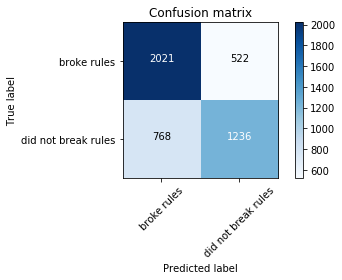

In [37]:
plot_confusion_matrix(confusion_matrix(violator_test.fillna(0),
                                       named_rf.predict(pd.get_dummies(named_test).fillna(0))),
                     ['broke rules', 'did not break rules'])

## Modelling

In [38]:
# some basic models
logit = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1500)
logit.fit(named_train, violator_train)
print(classification_report(violator_test, logit.predict(named_test)))

              precision    recall  f1-score   support

         0.0       0.64      0.75      0.69      2543
         1.0       0.60      0.47      0.53      2004

   micro avg       0.63      0.63      0.63      4547
   macro avg       0.62      0.61      0.61      4547
weighted avg       0.62      0.63      0.62      4547



In [39]:
# this is a function to repeat the process with the different types of violations
def run_specs(model, model_name, target_val,):
    current_job = "Current job: " + model_name + ", Target: " + target_val
    print(current_job)
    
    #runs model
    named_train, named_test, violator_train, violator_test = train_test_split(pd.get_dummies(named.fillna(0)),
                                                                          y_cat[target_val].fillna(0), random_state=seed) 
    model.fit(pd.get_dummies(named_train.fillna(0)),violator_train.fillna(0))
     
    #prints f1 score
    print(f1_score(y_true=violator_train.fillna(0),
                   y_pred=model.predict(pd.get_dummies(named_train).fillna(0))))
    print(f1_score(violator_test.fillna(0), 
                   model.predict(pd.get_dummies(named_test).fillna(0))))
    
    #creates confusion matrix
    cf_title = "Confusion Matrix: " + model_name + " Target: " + target_val
    plot_confusion_matrix(confusion_matrix(violator_test.fillna(0),
                                       model.predict(pd.get_dummies(named_test).fillna(0))), 
                          ['broke rules', 'did not break rules'], title = cf_title)

In [40]:
#defines models to be used:
ada_boost = AdaBoostClassifier()
nb = GaussianNB()
kde = KernelDensity()
k_means = KMeans()
k_nn = KNeighborsClassifier()
rf = RandomForestClassifier()
gradient_boost = GradientBoostingClassifier()
xgb = xgboost.XGBClassifier()

In [41]:
#doesn't work for other models 
#for i in y_cat.columns:
#    run_specs(k_nn, "k_means", i)

In [42]:
def gridsearching(model, X_train, X_test, y_train, y_test):
    #fits the chosen model to the data
   model.fit(X_train, y_train)
    #ouputs best parameters
   print("Best Params: {}".format(model.best_params_))
   y_pred_train = model.predict(X_train)
   print("Train F1: {}".format(f1_score(y_train, y_pred_train, average="macro")))
   print("Test Classification Report:")
   y_pred_test = model.predict(X_test)
    #presents classification scores
   print(classification_report(y_test, y_pred_test))
   print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                    accuracy_score(y_test, y_pred_test)))

In [43]:
# random forest
gs_params = GridSearchCV(rf, {'max_depth': [4,5,6], 'n_estimators': [100,150,200]}, scoring="f1_macro", cv=5)
gridsearching(gs_params, named_train, named_test, violator_train, violator_test)

Best Params: {'max_depth': 6, 'n_estimators': 100}
Train F1: 0.6897555626777889
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.81      0.74      2543
         1.0       0.68      0.52      0.59      2004

   micro avg       0.68      0.68      0.68      4547
   macro avg       0.68      0.67      0.67      4547
weighted avg       0.68      0.68      0.68      4547

Train Accuracy: 0.7028889866549347	Test accuracy: 0.6828678249395206


In [44]:
# k nearest neighbours
gs_params = GridSearchCV(k_nn, {'n_neighbors': [5,7], 'leaf_size': [25,30], 'p':[2]}, scoring="f1_macro", cv=5)
gridsearching(gs_params, named_train, named_test, violator_train, violator_test)

Best Params: {'leaf_size': 25, 'n_neighbors': 7, 'p': 2}
Train F1: 0.7391472931334806
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70      2543
         1.0       0.62      0.58      0.60      2004

   micro avg       0.66      0.66      0.66      4547
   macro avg       0.65      0.65      0.65      4547
weighted avg       0.66      0.66      0.66      4547

Train Accuracy: 0.743437454172166	Test accuracy: 0.6582361996921047


In [45]:
# gradient boost
gs_params = GridSearchCV(gradient_boost, {"learning_rate": [.1], "n_estimators": [100,], 
                                'max_depth': [1]}, scoring='f1_macro', cv=5)
gridsearching(gs_params, named_train, named_test, violator_train, violator_test)

Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
Train F1: 0.6908117413854238
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74      2543
         1.0       0.68      0.59      0.63      2004

   micro avg       0.69      0.69      0.69      4547
   macro avg       0.69      0.68      0.68      4547
weighted avg       0.69      0.69      0.69      4547

Train Accuracy: 0.6997360316761989	Test accuracy: 0.6934242357598417


In [46]:
# no tuning necessary for naive bayes
nb.fit(named_train, violator_train)
print(classification_report(violator_test, nb.predict(named_test)))

              precision    recall  f1-score   support

         0.0       0.65      0.77      0.70      2543
         1.0       0.62      0.46      0.53      2004

   micro avg       0.64      0.64      0.64      4547
   macro avg       0.63      0.62      0.62      4547
weighted avg       0.63      0.64      0.63      4547



In [47]:
# ada
gs_params = GridSearchCV(ada_boost, {"n_estimators": [75,100,125], 'learning_rate': [0.85,0.9,0.95]},
                         scoring='f1_macro', cv=5, )
gridsearching(gs_params, named_train, named_test, violator_train, violator_test)

Best Params: {'learning_rate': 0.9, 'n_estimators': 125}
Train F1: 0.7175098829652535
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      2543
         1.0       0.69      0.66      0.67      2004

   micro avg       0.72      0.72      0.72      4547
   macro avg       0.71      0.71      0.71      4547
weighted avg       0.72      0.72      0.72      4547

Train Accuracy: 0.7222466637336853	Test accuracy: 0.7176160105564108


In [48]:
# xgb
gs_params = GridSearchCV(xgb, {"n_estimators": [20, 25], 'learning_rate': [0.9,0.95],
                               'subsample':[0.75], 'n_jobs':[-1]},
                         scoring='f1_macro', cv=5)
gridsearching(gs_params, named_train, named_test, violator_train, violator_test)

Best Params: {'learning_rate': 0.9, 'n_estimators': 25, 'n_jobs': -1, 'subsample': 0.75}
Train F1: 0.735200644729828
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.74      2543
         1.0       0.67      0.66      0.66      2004

   micro avg       0.70      0.70      0.70      4547
   macro avg       0.70      0.70      0.70      4547
weighted avg       0.70      0.70      0.70      4547

Train Accuracy: 0.7388180085056459	Test accuracy: 0.7039806465801628


In [50]:
# saving best models for use later
best_xgb = xgboost.XGBClassifier(learning_rate=0.9, n_estimators=25, subsample=0.75, n_jobs=-1)
best_ada = AdaBoostClassifier(learning_rate=0.9, n_estimators=125)
best_ada.fit(named_train, violator_train)
best_xgb.fit(named_train, violator_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=25,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.75)

## Visualization

<module 'matplotlib.pyplot' from '/Users/branchflower/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

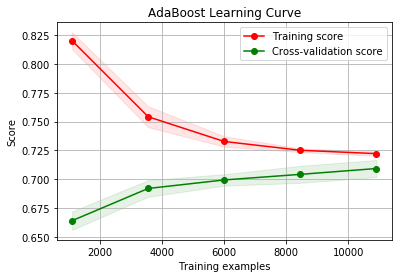

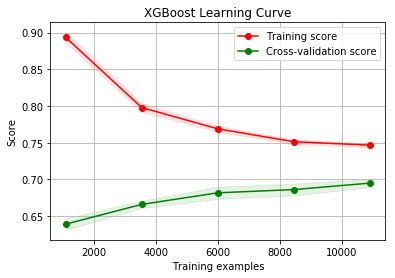

In [51]:
# CREDIT SCIKITLEARN DOCS: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# see ing if more data would be helpful
plot_learning_curve(best_ada, "AdaBoost Learning Curve", named_train, violator_train, cv=5)
plot_learning_curve(best_xgb, "XGBoost Learning Curve", named_train, violator_train, cv=5)

In [52]:
# getting predictions for each fo the types
for c in y_cat.columns:
    named_train, named_test, violation_type_train, violation_type_test = train_test_split(pd.get_dummies(named.fillna(0)),
                                                                          y_cat[c].fillna(0), random_state=seed)
    best_ada.fit(named_train, violation_type_train)
    best_xgb.fit(named_train, violation_type_train)
    print(f'{c} violations:\n')
    print('AdaBoost Results:')
    print(classification_report(violation_type_test, best_ada.predict(named_test)))
    print('XGBoost Results:')
    print(classification_report(violation_type_test, best_xgb.predict(named_test)))

drugs violations:

AdaBoost Results:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      4310
         1.0       0.50      0.11      0.18       237

   micro avg       0.95      0.95      0.95      4547
   macro avg       0.73      0.55      0.58      4547
weighted avg       0.93      0.95      0.93      4547

XGBoost Results:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      4310
         1.0       0.30      0.13      0.18       237

   micro avg       0.94      0.94      0.94      4547
   macro avg       0.63      0.56      0.57      4547
weighted avg       0.92      0.94      0.93      4547

alcohol violations:

AdaBoost Results:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      4451
         1.0       0.42      0.08      0.14        96

   micro avg       0.98      0.98      0.98      4547
   macro avg       0.70      0.54  

maj_violation violations:

AdaBoost Results:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      4414
         1.0       0.20      0.02      0.04       133

   micro avg       0.97      0.97      0.97      4547
   macro avg       0.59      0.51      0.51      4547
weighted avg       0.95      0.97      0.96      4547

XGBoost Results:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      4414
         1.0       0.15      0.05      0.08       133

   micro avg       0.96      0.96      0.96      4547
   macro avg       0.56      0.52      0.53      4547
weighted avg       0.95      0.96      0.96      4547

minor_violation violations:

AdaBoost Results:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      4202
         1.0       0.33      0.01      0.02       345

   micro avg       0.92      0.92      0.92      4547
   macro avg       

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 18185 samples in 0.679s...
[t-SNE] Computed neighbors for 18185 samples in 13.758s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18185
[t-SNE] Computed conditional probabilities for sample 2000 / 18185
[t-SNE] Computed conditional probabilities for sample 3000 / 18185
[t-SNE] Computed conditional probabilities for sample 4000 / 18185
[t-SNE] Computed conditional probabilities for sample 5000 / 18185
[t-SNE] Computed conditional probabilities for sample 6000 / 18185
[t-SNE] Computed conditional probabilities for sample 7000 / 18185
[t-SNE] Computed conditional probabilities for sample 8000 / 18185
[t-SNE] Computed conditional probabilities for sample 9000 / 18185
[t-SNE] Computed conditional probabilities for sample 10000 / 18185
[t-SNE] Computed conditional probabilities for sample 11000 / 18185
[t-SNE] Computed conditional probabilities for sample 12000 / 18185
[t-SNE] Computed conditional probabilities for s

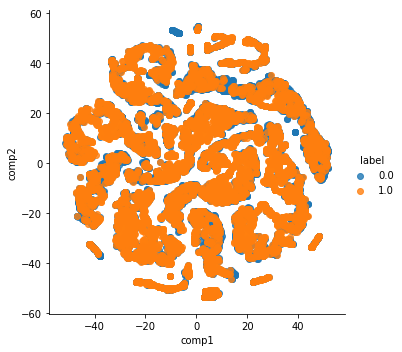

In [53]:
# visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=35,
                 n_iter=750, learning_rate=100, random_state=seed)
tsne_ = tsne.fit_transform(pd.get_dummies(named).fillna(0))
df_tsne = pd.DataFrame(tsne_, columns=['comp1', 'comp2'])
df_tsne['label'] = violator.values
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

In [54]:
# prediction on subset to new arriavls 
df_fresh_yr = pd.get_dummies(df[df.CS_SENTENCEMTH <= 12]).fillna(0)
fresh_violator = violator[df.CS_SENTENCEMTH <= 12].fillna(0)
fresh_train, fresh_test, fresh_v_train, fresh_v_test = train_test_split(df_fresh_yr, fresh_violator)
fresh_ada = AdaBoostClassifier(learning_rate=0.9, n_estimators=125)
fresh_ada.fit(df_fresh_yr, fresh_violator)
print(classification_report(fresh_v_test, fresh_ada.predict(fresh_test)))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       229
         1.0       0.88      0.77      0.82        88

   micro avg       0.91      0.91      0.91       317
   macro avg       0.90      0.87      0.88       317
weighted avg       0.91      0.91      0.91       317



In [55]:
# prediciton without race in the model
df_no_race = pd.get_dummies(df.drop(columns="RACE")).fillna(0)
no_race_train, no_race_test, no_race_v_train, no_race_v_test = train_test_split(df_no_race, violator,
                                                                               random_state=seed)
no_race_ada = AdaBoostClassifier(learning_rate=0.9, n_estimators=125, random_state=seed)
no_race_ada.fit(no_race_train, no_race_v_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9, n_estimators=125, random_state=17)

In [56]:
print("WITHOUT RACE:")
print(classification_report(no_race_v_test, no_race_ada.predict(no_race_test)))
print("WITH RACE:")
best_ada.fit(named_train, violator_train)
print(classification_report(violator_test, best_ada.predict(named_test)))

WITHOUT RACE:
              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      2543
         1.0       0.72      0.68      0.70      2004

   micro avg       0.74      0.74      0.74      4547
   macro avg       0.74      0.74      0.74      4547
weighted avg       0.74      0.74      0.74      4547

WITH RACE:
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      2543
         1.0       0.69      0.66      0.67      2004

   micro avg       0.72      0.72      0.72      4547
   macro avg       0.71      0.71      0.71      4547
weighted avg       0.72      0.72      0.72      4547



Confusion matrix, without normalization
[[1935  608]
 [ 676 1328]]


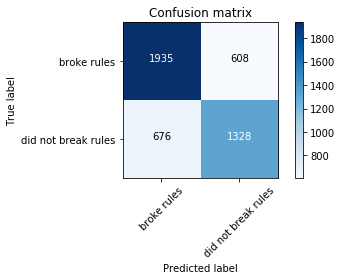

In [59]:
# a visual representation of our best results
plot_confusion_matrix(confusion_matrix(violator_test.fillna(0), best_ada.predict(pd.get_dummies(named_test).fillna(0))),
                     ['broke rules', 'did not break rules'])